# Import files

In [21]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter, zoom
from sklearn.preprocessing import MinMaxScaler
from matplotlib.animation import FuncAnimation
import imageio
import SimpleITK as sitk
from skimage import exposure
from skimage.filters import sobel, threshold_otsu
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.morphology import binary_dilation
from matplotlib.animation import FuncAnimation
from sklearn.cluster import KMeans

In [2]:
file_path_ip = "data/DIXON_joint_IP.nii"
file_path_op = "data/DIXON_joint_OP.nii"
file_path_water = "data/DIXON_joint_water.nii"
file_path_fat = "data/DIXON_joint_fat.nii"

nii_img_ip = nib.load(file_path_ip)
nii_img_op = nib.load(file_path_op)
nii_img_water = nib.load(file_path_water)
nii_img_fat = nib.load(file_path_fat)

In [8]:
data_ip = nii_img_ip.get_fdata()
data_op = nii_img_op.get_fdata()
data_water = nii_img_water.get_fdata()
data_fat = nii_img_fat.get_fdata()

In [6]:
min_ip, max_ip = data_ip.min(), data_ip.max()
min_op, max_op = data_op.min(), data_op.max()
min_water, max_water = data_water.min(), data_water.max()
min_fat, max_fat = data_fat.min(), data_fat.max()

In [ ]:
print("IP Image: Min =", min_ip, ", Max =", max_ip)
print("OP Image: Min =", min_op, ", Max =", max_op)
print("Water Image: Min =", min_water, ", Max =", max_water)
print("Fat Image: Min =", min_fat, ", Max =", max_fat)

IP Image: Min = 0.0 , Max = 109786.03125
OP Image: Min = 0.0 , Max = 99474.640625
Water Image: Min = 0.0 , Max = 81884.609375
Fat Image: Min = 0.0 , Max = 103316.140625


# Data Extraction, Gaussian Filtering and Initial Rescaling

In [ ]:
data_ip = nii_img_ip.get_fdata()
data_op = nii_img_op.get_fdata()
data_water = nii_img_water.get_fdata()
data_fat = nii_img_fat.get_fdata()

sigma = 1  
data_ip_filtered = gaussian_filter(data_ip, sigma=sigma)
data_op_filtered = gaussian_filter(data_op, sigma=sigma)
data_water_filtered = gaussian_filter(data_water, sigma=sigma)
data_fat_filtered = gaussian_filter(data_fat, sigma=sigma)

In [17]:
mese_resolution = [1.0, 1.0, 1.0]  
dixon_resolution = [1.5, 1.5, 1.5] 
scale_factor = [new / old for new, old in zip(mese_resolution, dixon_resolution)]

data_ip_rescaled = zoom(data_ip_filtered, scale_factor, order=1)
data_op_rescaled = zoom(data_op_filtered, scale_factor, order=1)
data_water_rescaled = zoom(data_water_filtered, scale_factor, order=1)
data_fat_rescaled = zoom(data_fat_filtered, scale_factor, order=1)

# Animation


Animation saved as mri_slices_animation.gif


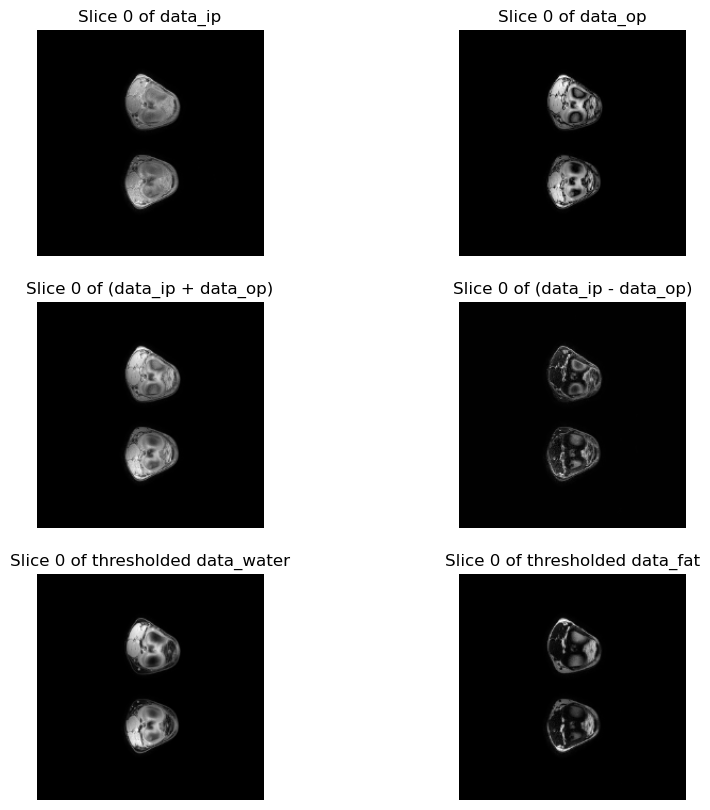

In [ ]:
fat_threshold = 0.5  
water_threshold = 0.5  

# Apply thresholds
data_fat_thresholded = np.where(data_fat_rescaled > fat_threshold, data_fat_rescaled, 0)
data_water_thresholded = np.where(data_water_rescaled > water_threshold, data_water_rescaled, 0)

fig, axs = plt.subplots(3, 2, figsize=(10, 10))

def update(i):
    for ax in axs.flatten():
        ax.clear()
    
    axs[0, 0].imshow(data_ip_rescaled[:, :, i], cmap="gray")
    axs[0, 0].set_title(f"Slice {i} of data_ip")
    axs[0, 0].axis("off")

    axs[0, 1].imshow(data_op_rescaled[:, :, i], cmap="gray")
    axs[0, 1].set_title(f"Slice {i} of data_op")
    axs[0, 1].axis("off")

    axs[1, 0].imshow((data_ip_rescaled[:, :, i] + data_op_rescaled[:, :, i]) / 2, cmap="gray")
    axs[1, 0].set_title(f"Slice {i} of (data_ip + data_op)")
    axs[1, 0].axis("off")

    axs[1, 1].imshow((data_ip_rescaled[:, :, i] - data_op_rescaled[:, :, i]) / 2, cmap="gray")
    axs[1, 1].set_title(f"Slice {i} of (data_ip - data_op)")
    axs[1, 1].axis("off")

    axs[2, 0].imshow(data_water_thresholded[:, :, i], cmap="gray")
    axs[2, 0].set_title(f"Slice {i} of thresholded data_water")
    axs[2, 0].axis("off")

    axs[2, 1].imshow(data_fat_thresholded[:, :, i], cmap="gray")
    axs[2, 1].set_title(f"Slice {i} of thresholded data_fat")
    axs[2, 1].axis("off")

num_slices = data_ip_rescaled.shape[2]
anim = FuncAnimation(fig, update, frames=range(0, num_slices, 10), interval=200)

output_path = "mri_slices_animation.gif"
anim.save(output_path, writer="pillow", fps=5)

print(f"Animation saved as {output_path}")

# Image Registration 

In [6]:
fixed_image = sitk.GetImageFromArray(data_ip_rescaled)  
moving_image = sitk.GetImageFromArray(data_op_rescaled)  
transform = sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.Euler3DTransform())
registered_image = sitk.Resample(moving_image, fixed_image, transform, sitk.sitkLinear, 0.0)
registered_data_op = sitk.GetArrayFromImage(registered_image)

# K-means Clustering for Subcutaneous Fat Segmentation

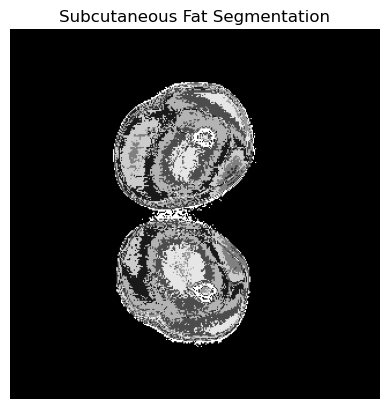

In [28]:
water_fat_combined = data_water + data_fat
kmeans = KMeans(n_clusters= 11).fit(water_fat_combined.reshape(-1, 1))
segmentation_mask = kmeans.labels_.reshape(water_fat_combined.shape)

plt.imshow(segmentation_mask[:, :, segmentation_mask.shape[2] // 2], cmap="gray")
plt.title("Subcutaneous Fat Segmentation")
plt.axis("off")
plt.show()

#  Thresholding

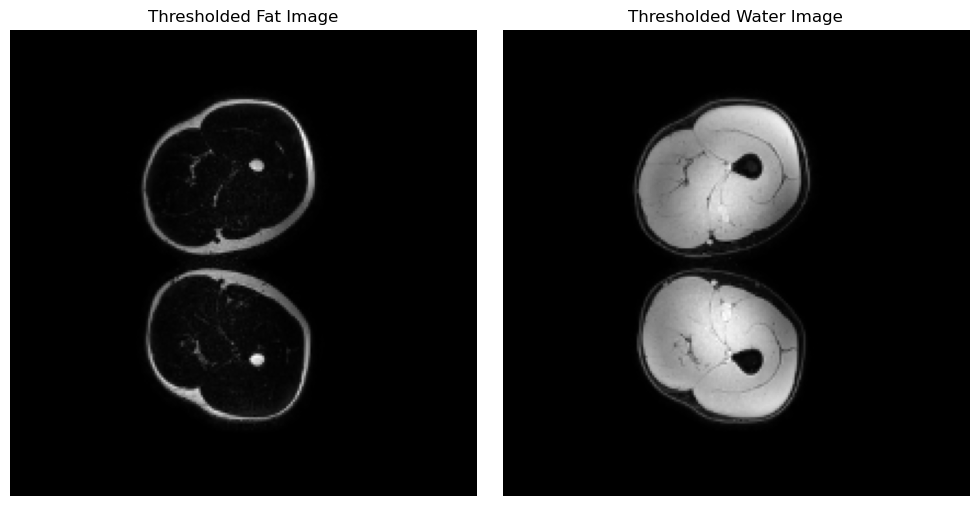

In [ ]:
fat_threshold = 0.5  
water_threshold = 0.5  

data_fat_thresholded = np.where(data_fat_rescaled > fat_threshold, data_fat_rescaled, 0)
data_water_thresholded = np.where(data_water_rescaled > water_threshold, data_water_rescaled, 0)

slice_idx = data_fat_thresholded.shape[2] // 2  
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(data_fat_thresholded[:, :, slice_idx], cmap="gray")
plt.title("Thresholded Fat Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(data_water_thresholded[:, :, slice_idx], cmap="gray")
plt.title("Thresholded Water Image")
plt.axis("off")

plt.tight_layout()
plt.show()

# Normalization

In [11]:
scaler = MinMaxScaler()


def normalize_data(data):
    data_normalized = np.zeros_like(data)
    for i in range(data.shape[2]):
        slice_data = data[:, :, i].reshape(-1, 1)
        data_normalized[:, :, i] = scaler.fit_transform(slice_data).reshape(data.shape[0], data.shape[1])
    return data_normalized


data_ip_normalized = normalize_data(data_ip_rescaled)
data_op_normalized = normalize_data(data_op_rescaled)
data_water_normalized = normalize_data(data_water_rescaled)
data_fat_normalized = normalize_data(data_fat_rescaled)

data_ip_original_normalized = normalize_data(data_ip)
data_op_original_normalized = normalize_data(data_op)
data_water_original_normalized = normalize_data(data_water)
data_fat_original_normalized = normalize_data(data_fat)

In [14]:
min_ip, max_ip = data_ip_original_normalized.min(), data_ip_original_normalized.max()
min_op, max_op = data_op_original_normalized.min(), data_op_original_normalized.max()
min_water, max_water = data_water_original_normalized.min(), data_water_original_normalized.max()
min_fat, max_fat = data_fat_original_normalized.min(), data_fat_original_normalized.max()


print("IP Image: Min =", min_ip, ", Max =", max_ip)
print("oP Image: Min =", min_op, ", Max =", max_op)
print("Fat Image: Min =",min_fat, ", Max =", max_fat)
print("water Image: Min =", min_water, ", Max =", max_water)

IP Image: Min = 0.0 , Max = 1.0
oP Image: Min = 0.0 , Max = 1.0
Fat Image: Min = 0.0 , Max = 1.0
water Image: Min = 0.0 , Max = 1.0


# Histpgram Equalization

In [12]:
from skimage import exposure

def apply_histogram_equalization(data):
    data_equalized = np.zeros_like(data)
    for i in range(data.shape[2]):
        data_equalized[:, :, i] = exposure.equalize_hist(data[:, :, i])
    return data_equalized

data_ip_equalized = apply_histogram_equalization(data_ip_normalized)
data_op_equalized = apply_histogram_equalization(data_op_normalized)
data_water_equalized = apply_histogram_equalization(data_water_normalized)
data_fat_equalized = apply_histogram_equalization(data_fat_normalized)

# Edge Detetion

In [13]:
from skimage.filters import sobel

def apply_edge_detection(data):
    edges = np.zeros_like(data)
    for i in range(data.shape[2]):
        edges[:, :, i] = sobel(data[:, :, i])
    return edges

data_ip_edges = apply_edge_detection(data_ip_normalized)
data_op_edges = apply_edge_detection(data_op_normalized)
data_water_edges = apply_edge_detection(data_water_normalized)
data_fat_edges = apply_edge_detection(data_fat_normalized)

# Segmentation using Otsu

In [14]:
from skimage.filters import threshold_otsu

def segment_image(data):
    segmented_data = np.zeros_like(data)
    for i in range(data.shape[2]):
        thresh = threshold_otsu(data[:, :, i])
        segmented_data[:, :, i] = data[:, :, i] > thresh
    return segmented_data

data_ip_segmented = segment_image(data_ip_normalized)
data_op_segmented = segment_image(data_op_normalized)
data_water_segmented = segment_image(data_water_normalized)
data_fat_segmented = segment_image(data_fat_normalized)

# Fourier Transform Low-Pass Filter

In [16]:
def fourier_lowpass_filter(data, cutoff=30):
    filtered_data = np.zeros_like(data)
    for i in range(data.shape[2]):
        f = np.fft.fft2(data[:, :, i])
        fshift = np.fft.fftshift(f)
        rows, cols = data[:, :, i].shape
        crow, ccol = rows // 2, cols // 2
        mask = np.zeros((rows, cols), np.uint8)
        mask[crow - cutoff:crow + cutoff, ccol - cutoff:ccol + cutoff] = 1
        fshift = fshift * mask
        f_ishift = np.fft.ifftshift(fshift)
        img_back = np.fft.ifft2(f_ishift)
        filtered_data[:, :, i] = np.abs(img_back)
    return filtered_data

data_ip_fourier = fourier_lowpass_filter(data_ip_normalized)
data_op_fourier = fourier_lowpass_filter(data_op_normalized)
data_water_fourier = fourier_lowpass_filter(data_water_normalized)
data_fat_fourier = fourier_lowpass_filter(data_fat_normalized)

# Visualize As Animation

In [ ]:
fig, axs = plt.subplots(4, 8, figsize=(20, 20))

def update(i):
    for ax in axs.flatten():
        ax.clear()

    
    axs[0, 0].imshow(data_ip_normalized[:, :, i], cmap="gray")
    axs[0, 0].set_title("Original IP")
    axs[0, 1].imshow(data_ip_equalized[:, :, i], cmap="gray")
    axs[0, 1].set_title("Equalized IP")
    axs[0, 2].imshow(data_ip_edges[:, :, i], cmap="gray")
    axs[0, 2].set_title("Edges IP")
    axs[0, 3].imshow(data_ip_segmented[:, :, i], cmap="gray")
    axs[0, 3].set_title("Segmented IP")
    axs[0, 4].imshow(data_ip_fourier[:, :, i], cmap="gray")
    axs[0, 4].set_title("Fourier IP")


num_slices = data_ip.shape[2]
anim = FuncAnimation(fig, update, frames=range(0, num_slices), interval=200)


anim.save("all_processing_comparison.gif", writer="pillow", fps=2)

print("Animation saved as 'all_processing_comparison.gif'")

# Processed vs. Unprocessed data

Animation saved as comparison_animation.gif


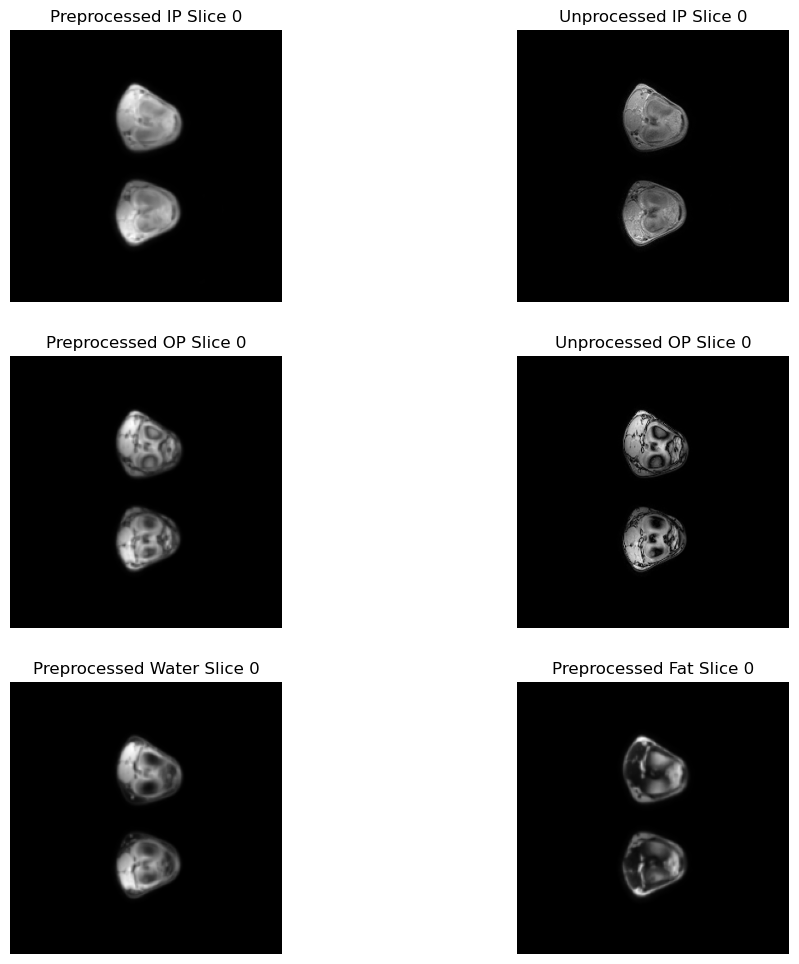

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))


def update(i):
    for ax in axs.flatten():
        ax.clear()


    axs[0, 0].imshow(data_ip_normalized[:, :, i], cmap="gray")
    axs[0, 0].set_title(f"Preprocessed IP Slice {i}")
    axs[0, 0].axis("off")

    axs[0, 1].imshow(data_ip_original_normalized[:, :, i], cmap="gray")
    axs[0, 1].set_title(f"Unprocessed IP Slice {i}")
    axs[0, 1].axis("off")

    axs[1, 0].imshow(data_op_normalized[:, :, i], cmap="gray")
    axs[1, 0].set_title(f"Preprocessed OP Slice {i}")
    axs[1, 0].axis("off")

    axs[1, 1].imshow(data_op_original_normalized[:, :, i], cmap="gray")
    axs[1, 1].set_title(f"Unprocessed OP Slice {i}")
    axs[1, 1].axis("off")

    axs[2, 0].imshow(data_water_normalized[:, :, i], cmap="gray")
    axs[2, 0].set_title(f"Preprocessed Water Slice {i}")
    axs[2, 0].axis("off")

    axs[2, 1].imshow(data_fat_normalized[:, :, i], cmap="gray")
    axs[2, 1].set_title(f"Preprocessed Fat Slice {i}")
    axs[2, 1].axis("off")


num_slices = data_ip_rescaled.shape[2]
anim = FuncAnimation(fig, update, frames=range(0, num_slices, 10), interval=200)


output_path = "comparison_animation.gif"
anim.save(output_path, writer="pillow", fps=1)


print(f"Animation saved as {output_path}")

# Visualization Loop

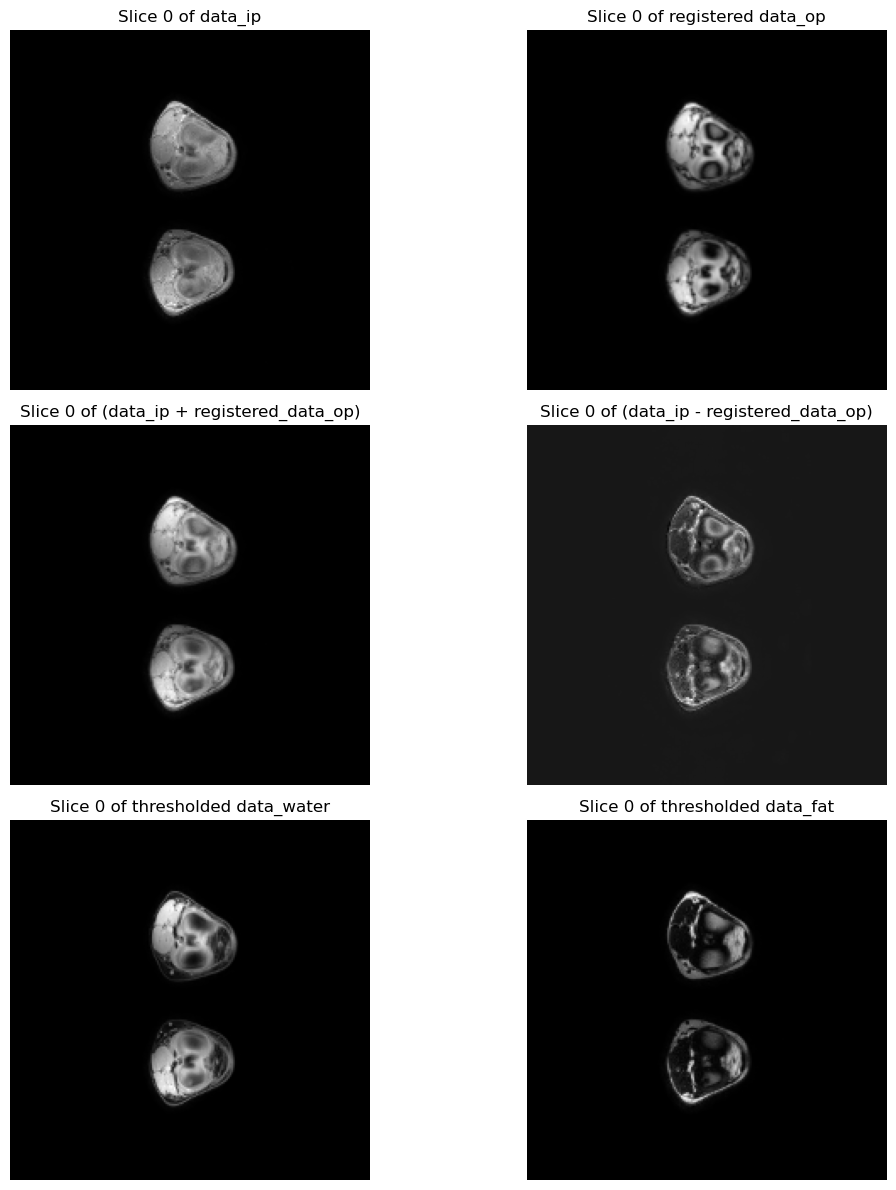

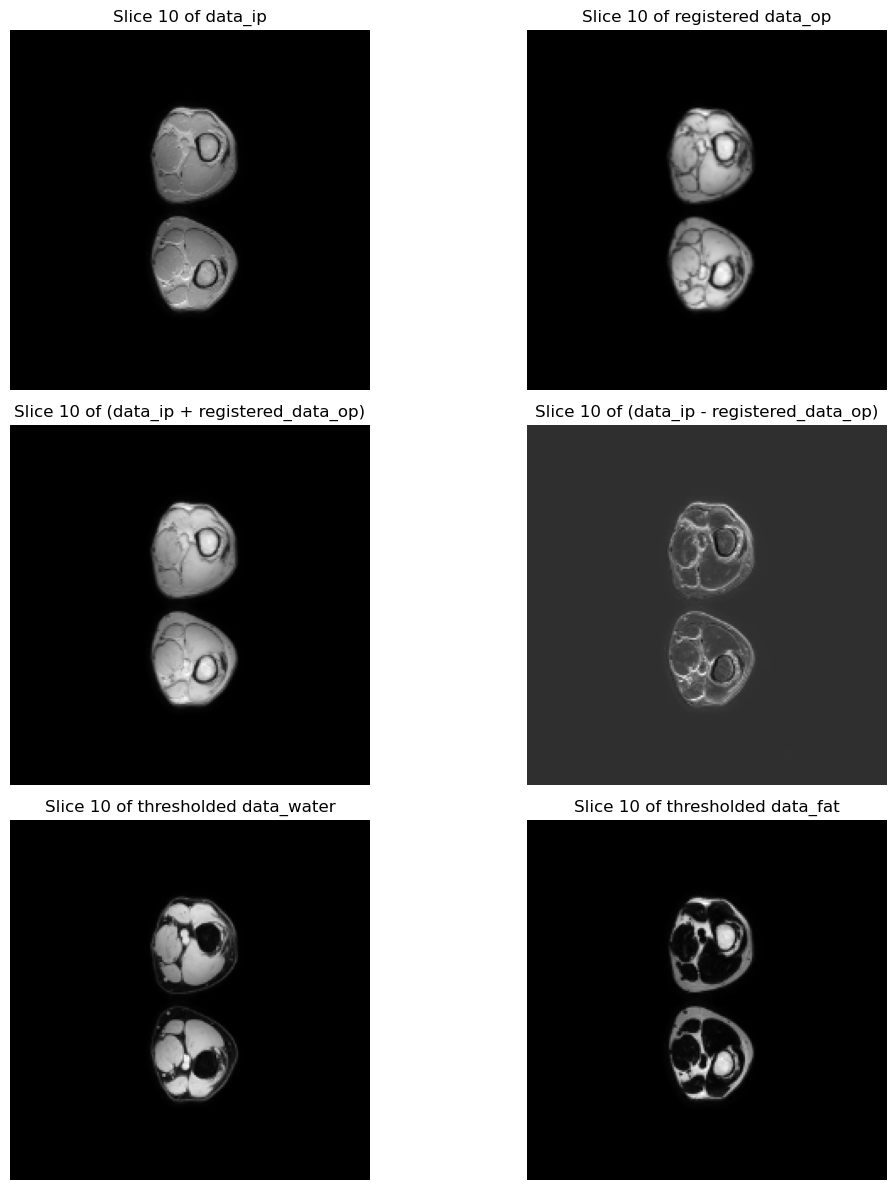

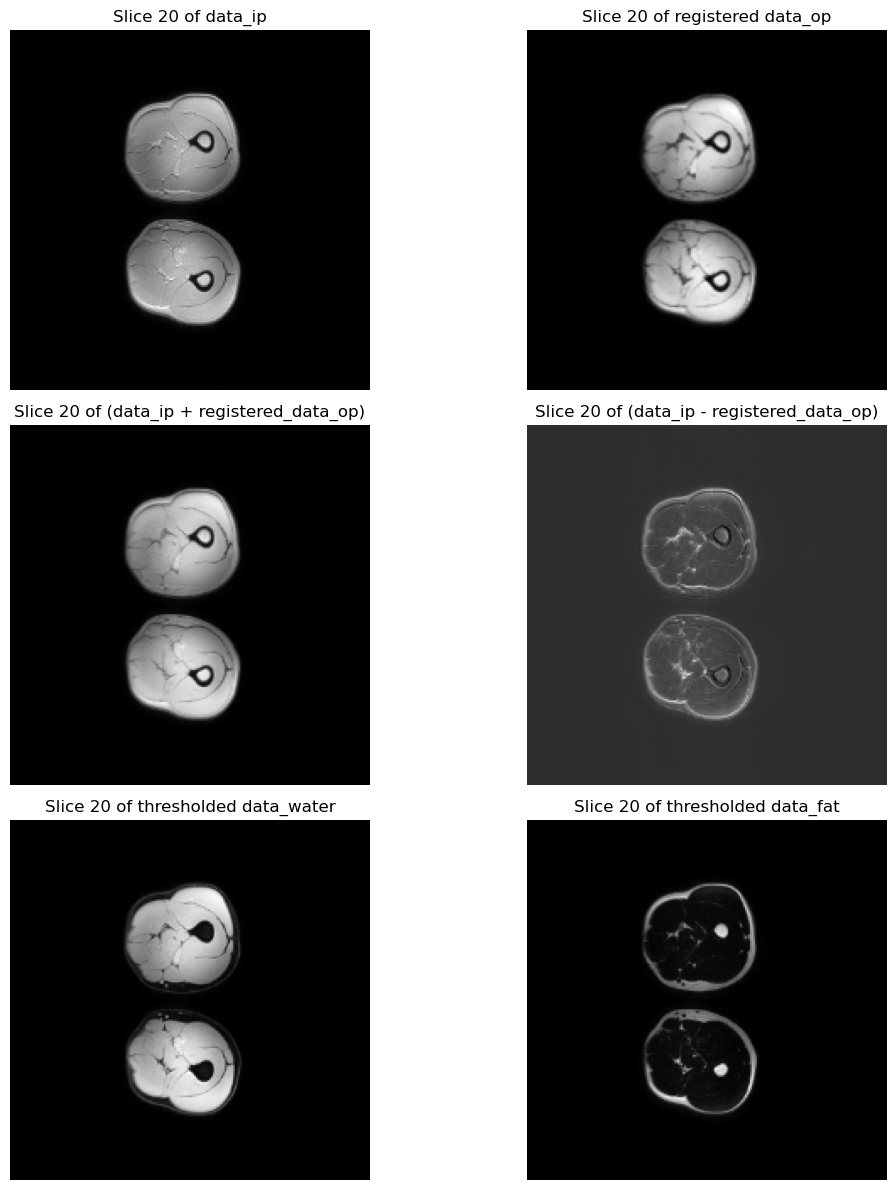

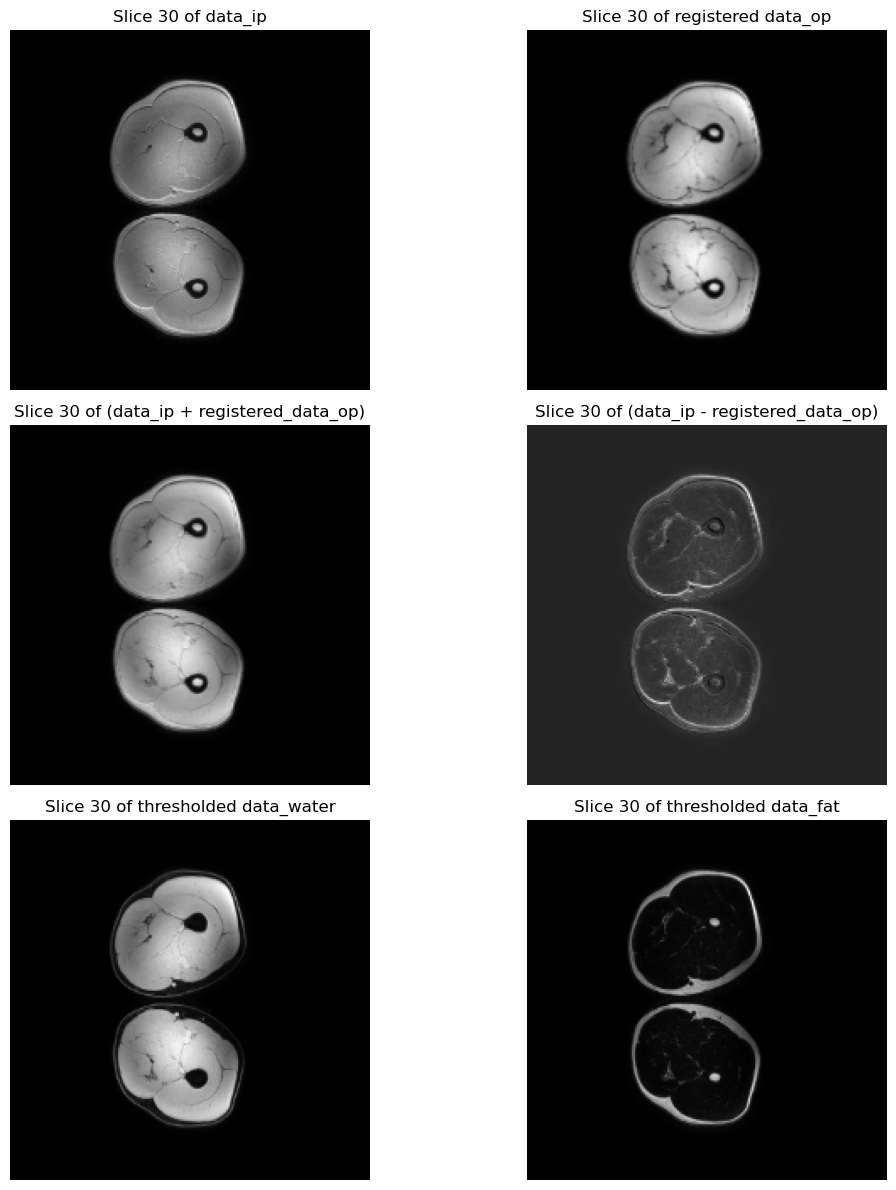

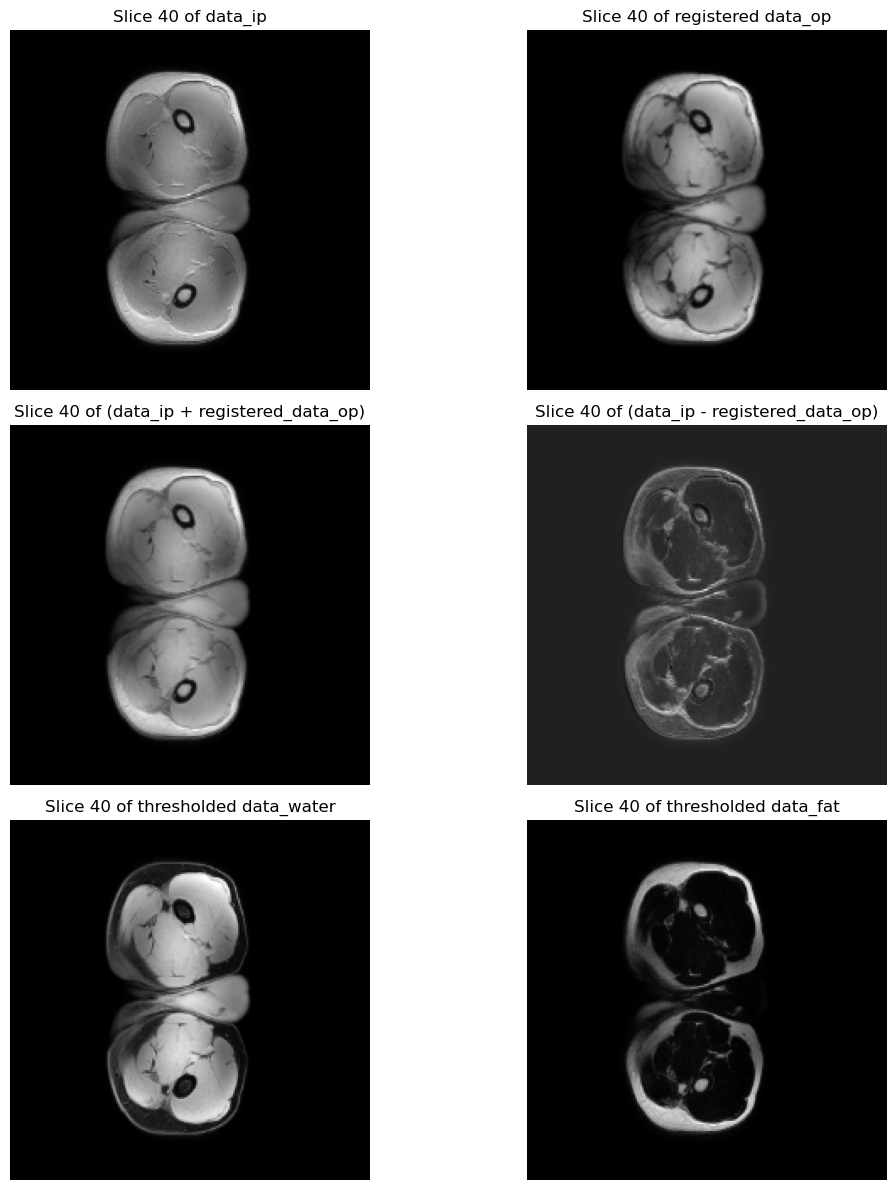

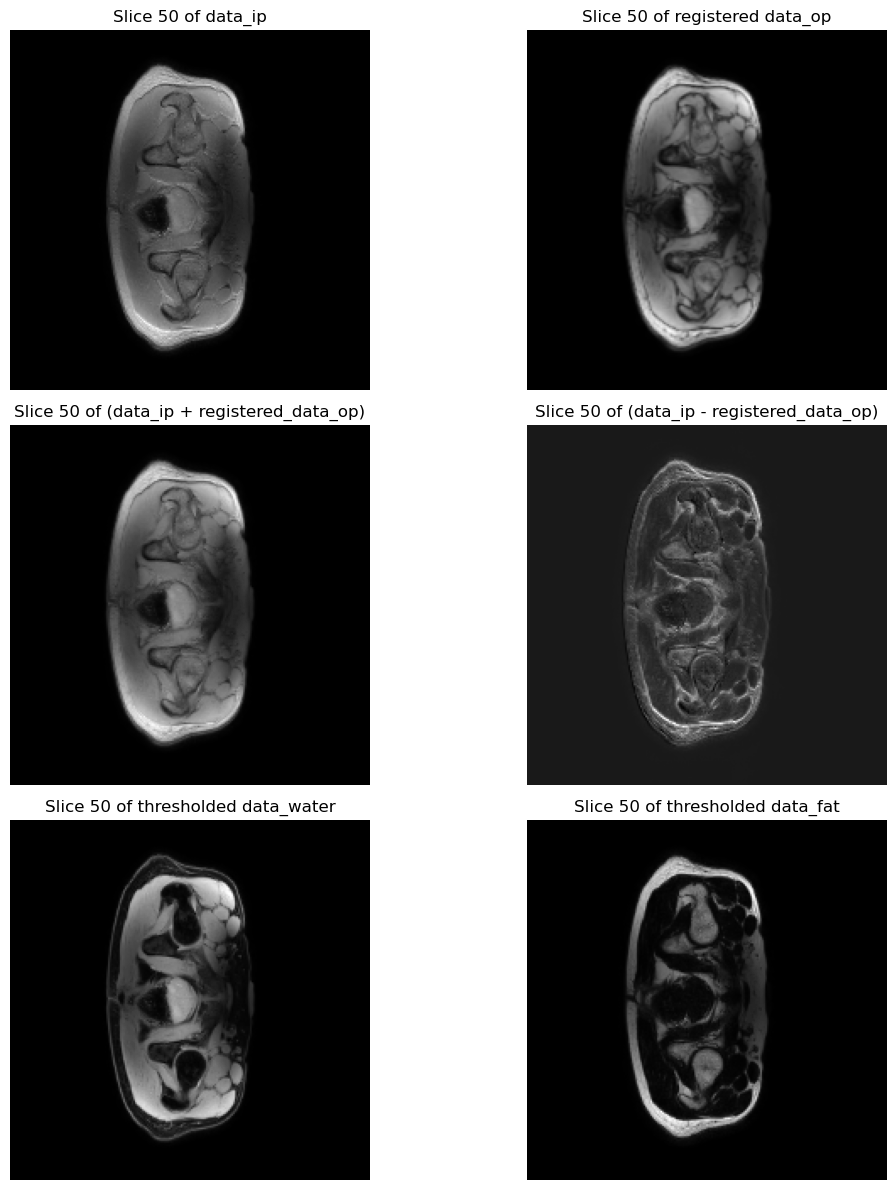

In [7]:
# Visualization loop through slices
for i in range(0, data_ip_rescaled.shape[2], 10):
    plt.figure(figsize=(12, 12))

    plt.subplot(3, 2, 1)
    plt.imshow(data_ip_rescaled[:, :, i], cmap="gray")
    plt.title(f"Slice {i} of data_ip")
    plt.axis("off")

    plt.subplot(3, 2, 2)
    plt.imshow(registered_data_op[:, :, i], cmap="gray")
    plt.title(f"Slice {i} of registered data_op")
    plt.axis("off")

    plt.subplot(3, 2, 3)
    plt.imshow((data_ip_rescaled[:, :, i] + registered_data_op[:, :, i]) / 2, cmap="gray")
    plt.title(f"Slice {i} of (data_ip + registered_data_op)")
    plt.axis("off")

    plt.subplot(3, 2, 4)
    plt.imshow((data_ip_rescaled[:, :, i] - registered_data_op[:, :, i]) / 2, cmap="gray")
    plt.title(f"Slice {i} of (data_ip - registered_data_op)")
    plt.axis("off")

    plt.subplot(3, 2, 5)
    plt.imshow(data_water_thresholded[:, :, i], cmap="gray")
    plt.title(f"Slice {i} of thresholded data_water")
    plt.axis("off")

    plt.subplot(3, 2, 6)
    plt.imshow(data_fat_thresholded[:, :, i], cmap="gray")
    plt.title(f"Slice {i} of thresholded data_fat")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


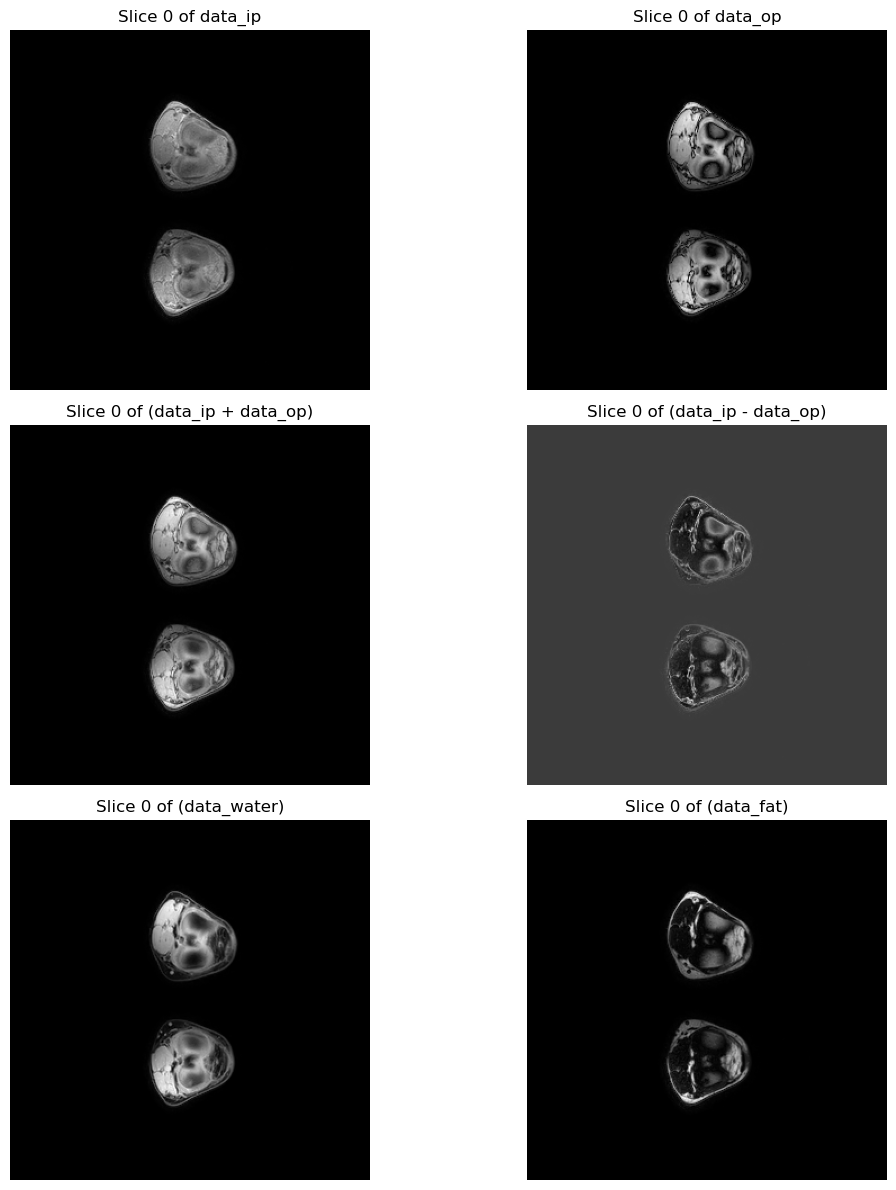

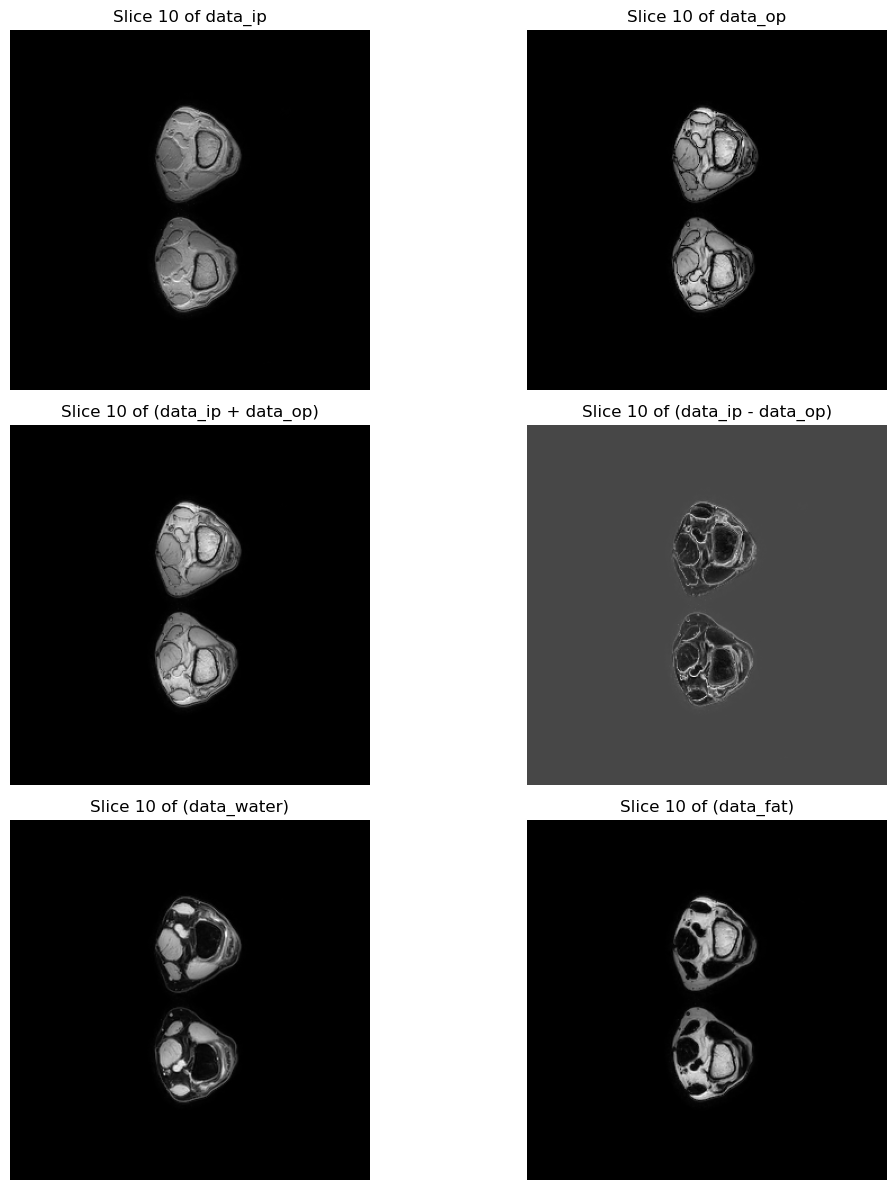

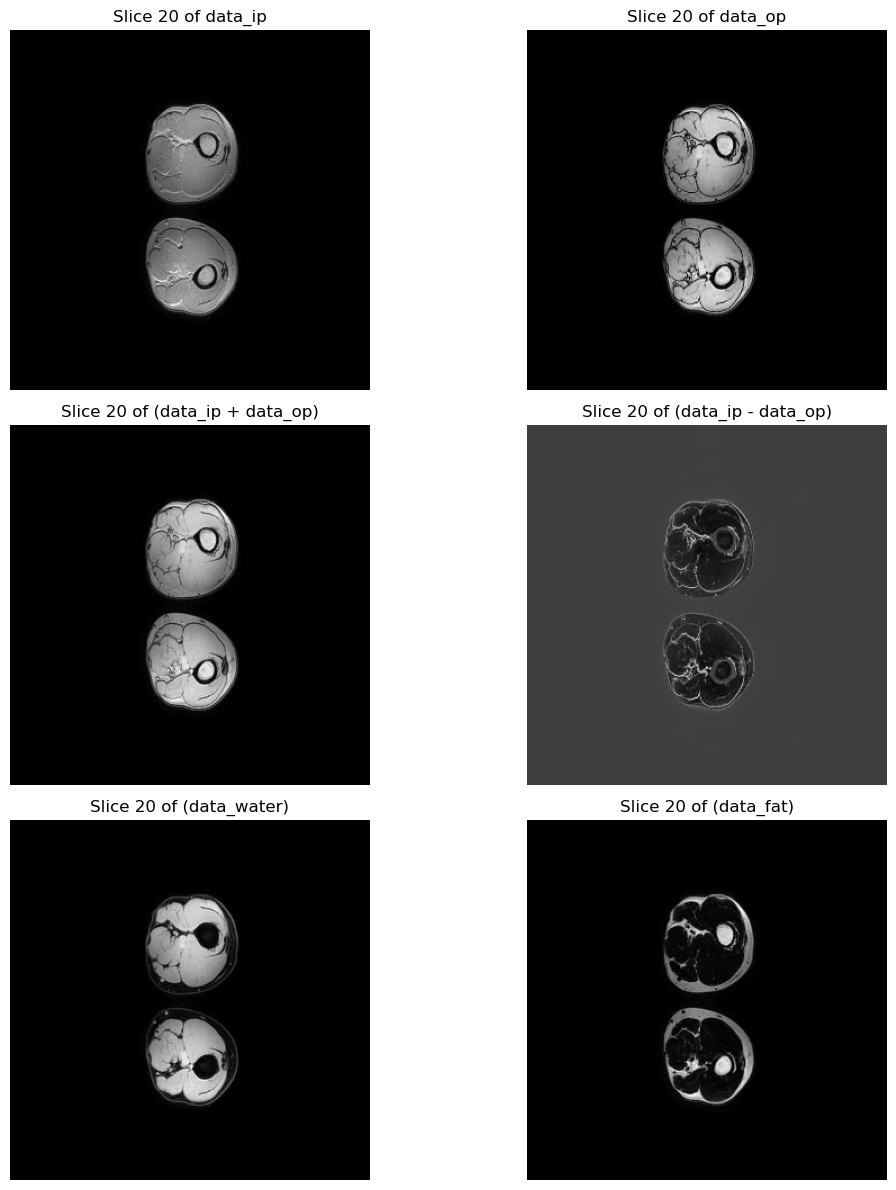

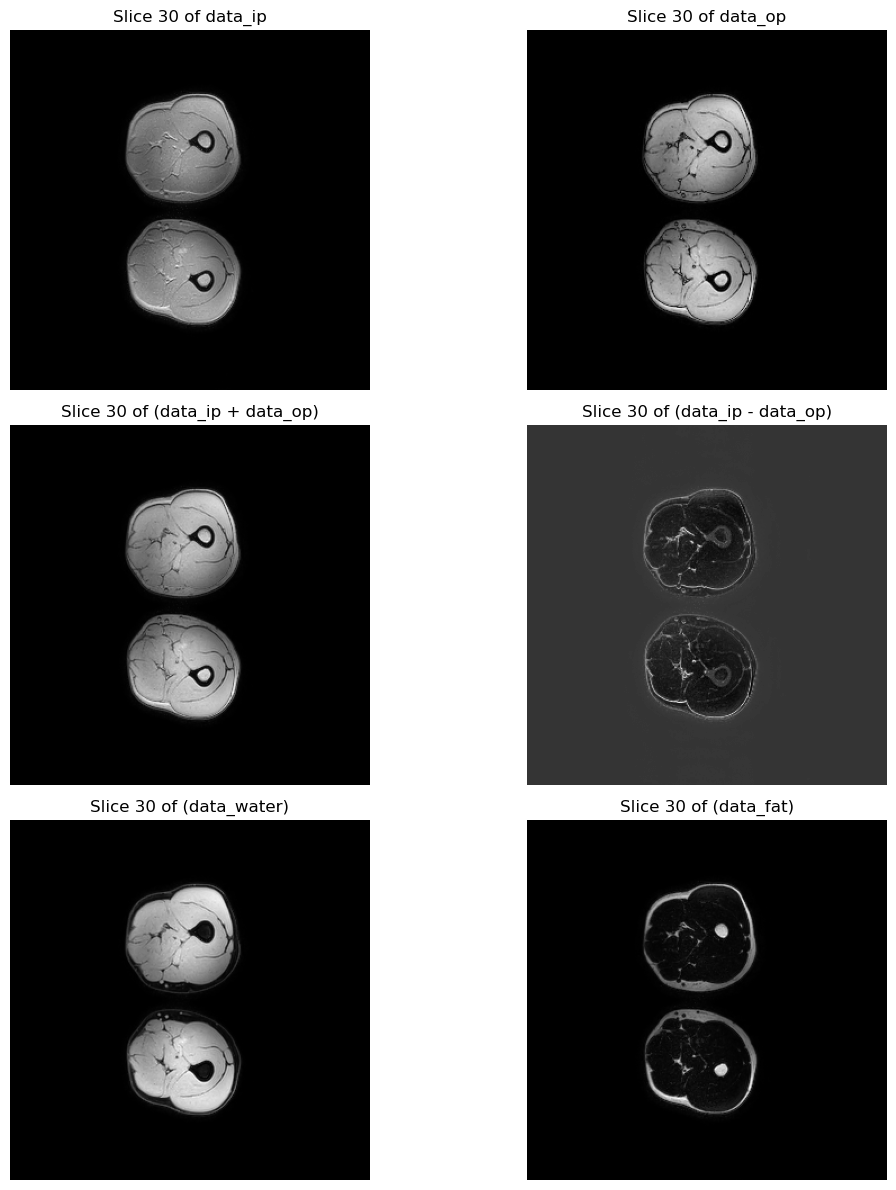

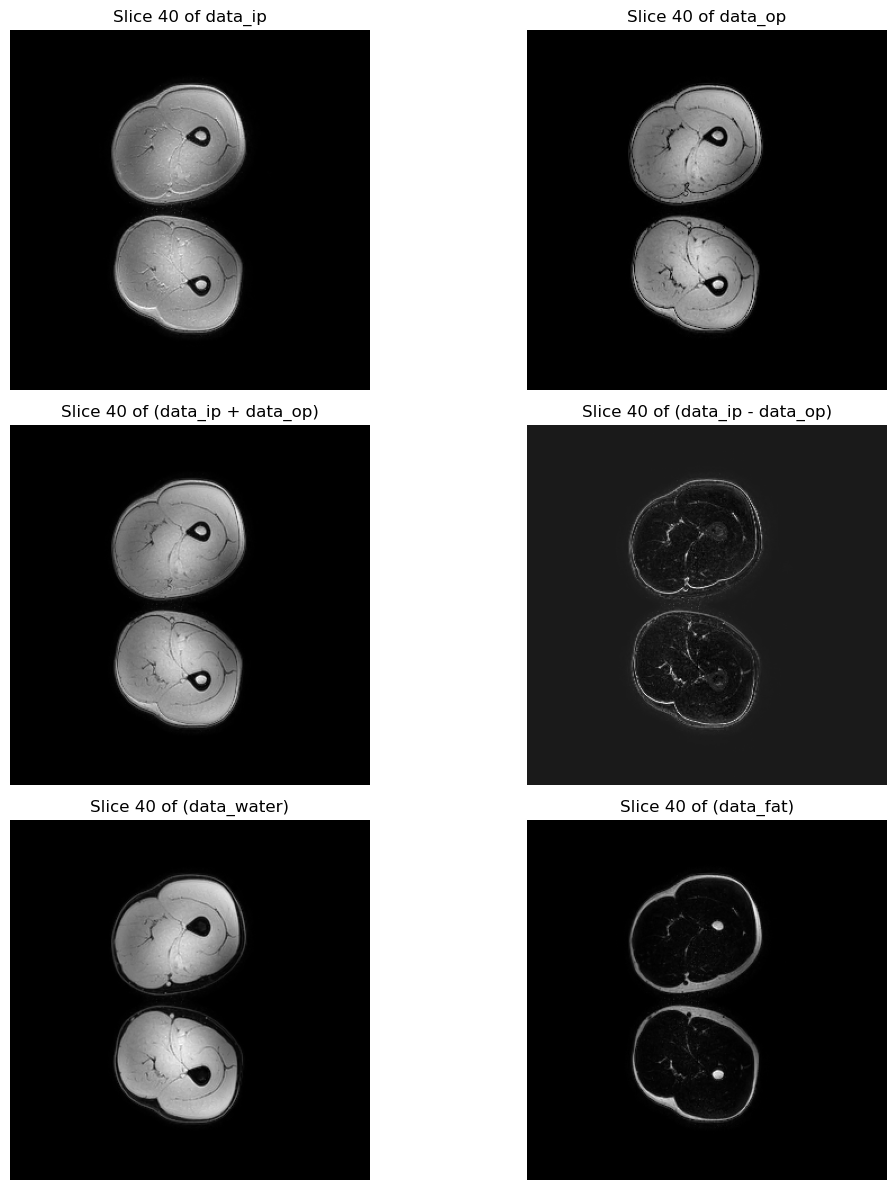

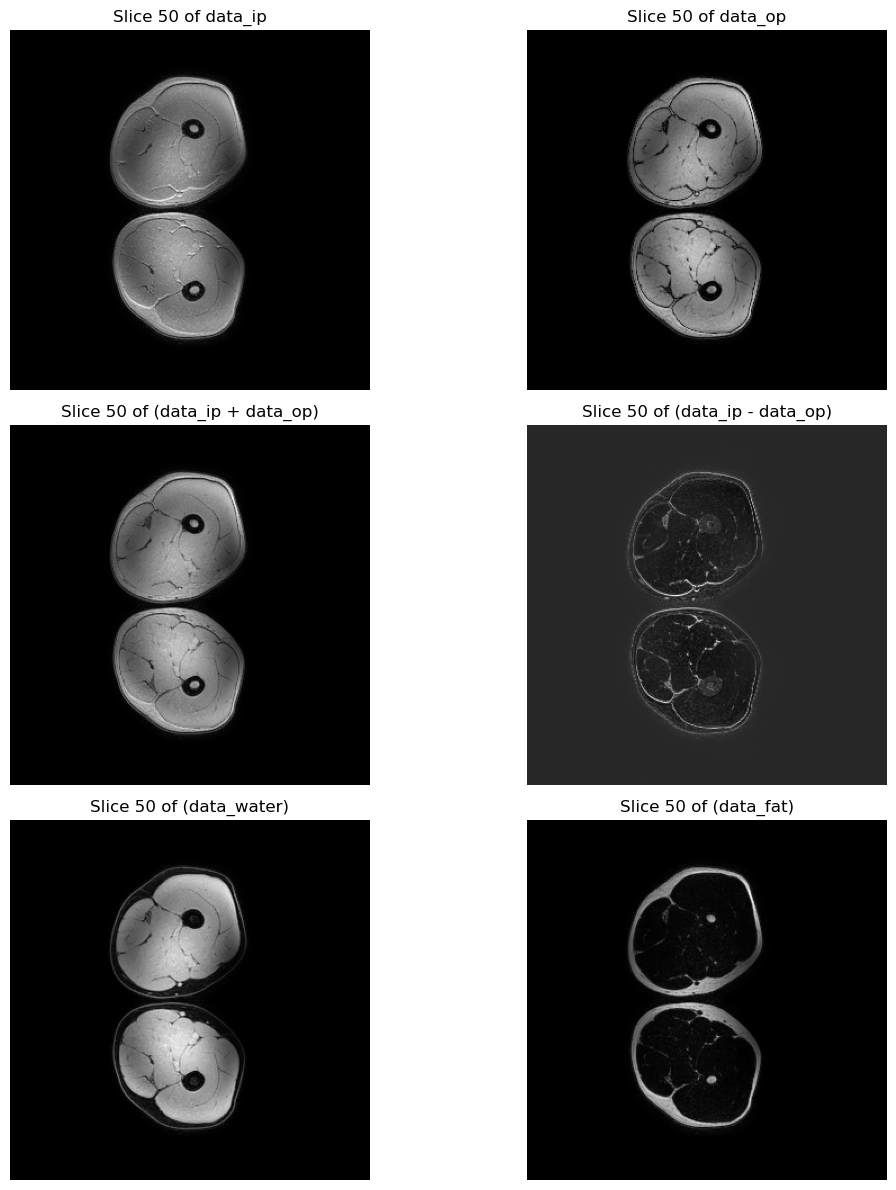

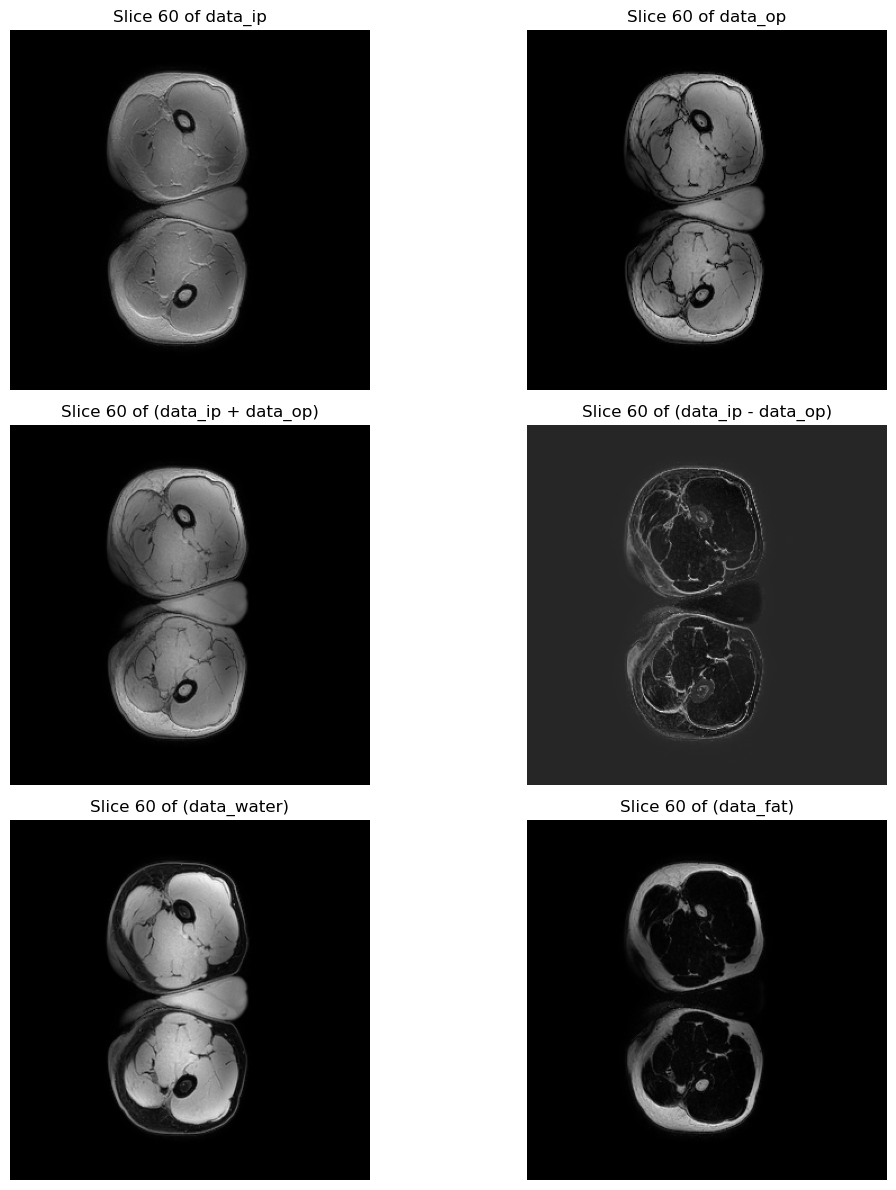

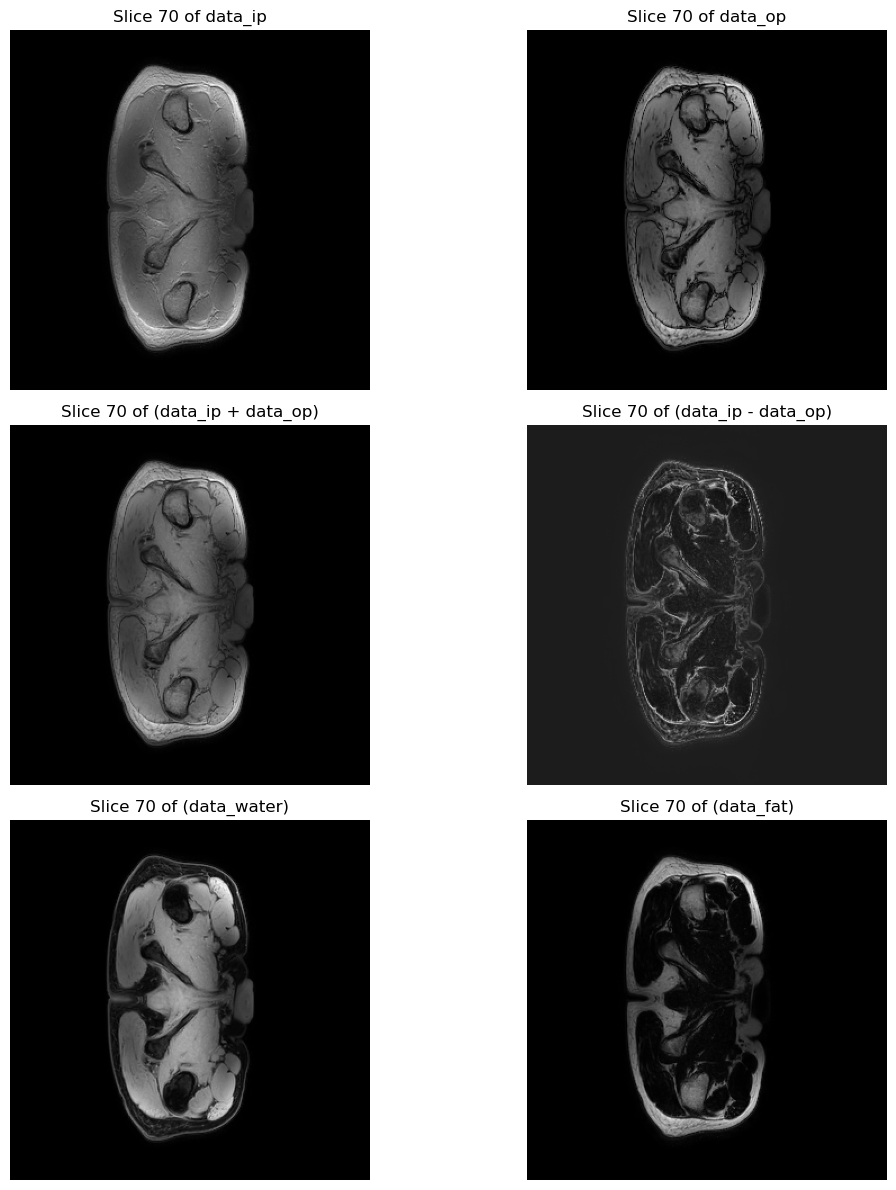

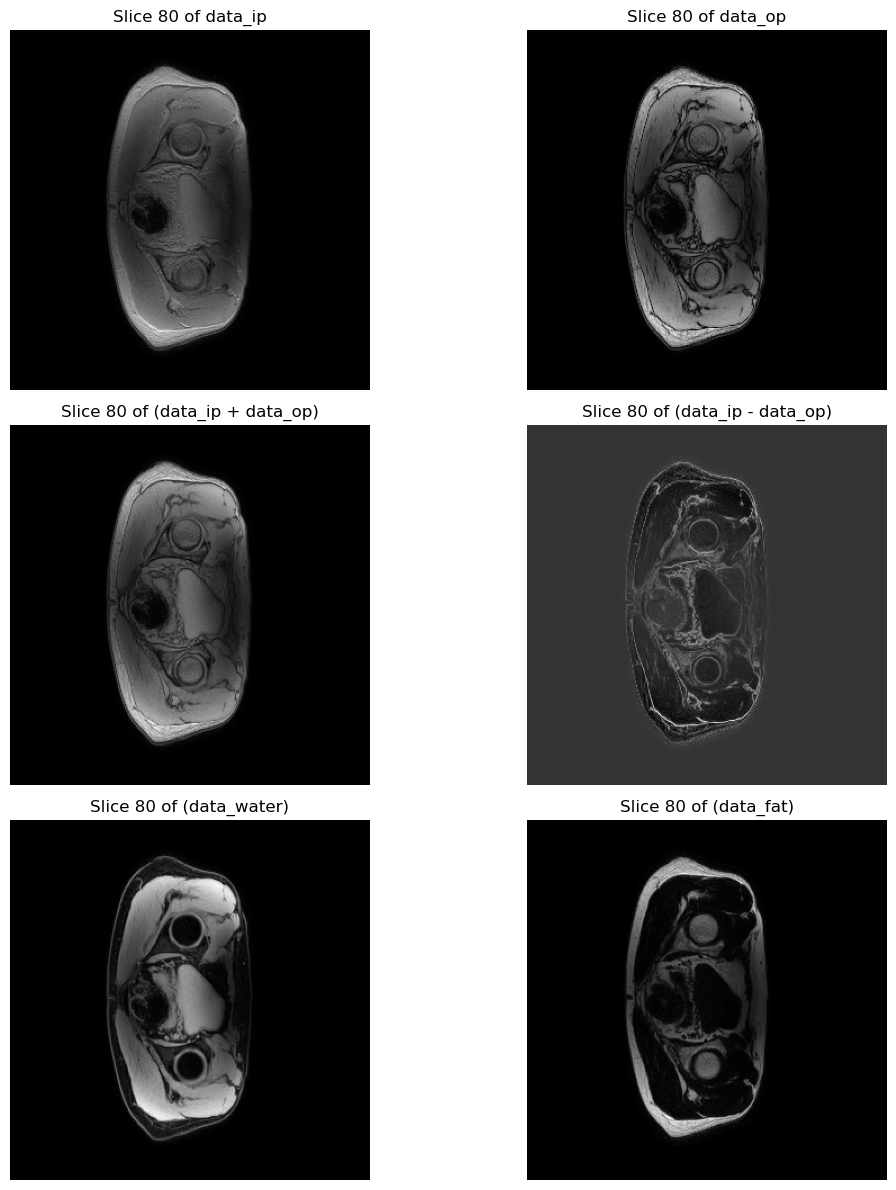

In [16]:
for i in range(0, data_ip.shape[2], 10):
    # Create a new figure for each set of 4 images
    plt.figure(figsize=(12, 12))
    
    # Plot the data_ip slice
    plt.subplot(3, 2, 1)
    plt.imshow(data_ip_original_normalized[:, :, i], cmap="gray")
    plt.title(f"Slice {i} of data_ip")
    plt.axis("off")

    # Plot the data_op slice
    plt.subplot(3, 2, 2)
    plt.imshow(data_op_original_normalized[:, :, i], cmap="gray")
    plt.title(f"Slice {i} of data_op")
    plt.axis("off")

    # Plot the combined (data_ip + data_op) slice
    plt.subplot(3, 2, 3)
    plt.imshow((data_ip_original_normalized[:, :, i] + data_op_original_normalized[:, :, i]) / 2, cmap="gray")
    plt.title(f"Slice {i} of (data_ip + data_op)")
    plt.axis("off")

    # Plot the difference (data_ip - data_op) slice
    plt.subplot(3, 2, 4)
    plt.imshow((data_ip_original_normalized[:, :, i] - data_op_original_normalized[:, :, i]) / 2, cmap="gray")
    plt.title(f"Slice {i} of (data_ip - data_op)")
    plt.axis("off")


    plt.subplot(3, 2, 5)
    plt.imshow(data_water_original_normalized[:, :, i], cmap="gray")
    plt.title(f"Slice {i} of (data_water)")
    plt.axis("off")

    # Plot the difference (data_ip - data_op) slice
    plt.subplot(3, 2, 6)
    plt.imshow(data_fat_original_normalized[:, :, i], cmap="gray")
    plt.title(f"Slice {i} of (data_fat)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()